## Simple EDA to understand the dataset
- whats in our dataset
- what do they look like

In [4]:
import pandas as pd
import numpy as np
import keras

In [2]:
%%time
train = pd.read_csv('../data/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
# note: this process took 2min 10scs on my computer

CPU times: user 1min 13s, sys: 15.7 s, total: 1min 28s
Wall time: 1min 26s


In [1]:
train_df = train

NameError: name 'train' is not defined

In [2]:
train_df.head()

NameError: name 'train_df' is not defined

In [16]:
train_df.shape

(629145480, 2)

## Calculate aggregated features

## LSTM Using Keras

In [6]:
chunk_size = 150000

chunks = int(np.floor(train_df.shape[0]/chunk_size))

X_data = pd.DataFrame(index=range(chunks), dtype=np.float32, columns=['min','max','std', 'avg', 'sum', 'median', 'mean_diff', 
                                                                       'q05', 'q25', 'q75', 'q95'])
y_data = pd.DataFrame(index=range(chunks), dtype=np.float32, columns=['ttf'])

def create_features(data_chunk, X_df, chunk_no, col_name='acoustic_data'):
    x = data_chunk[col_name]
    X_df.loc[chunk_no, 'min'] = x.min()
    X_df.loc[chunk_no, 'max'] = x.max()
    X_df.loc[chunk_no, 'std'] = x.std()
    X_df.loc[chunk_no, 'avg'] = x.mean()
    X_df.loc[chunk_no, 'sum'] = x.sum()
    X_df.loc[chunk_no, 'median'] = x.median()
    X_df.loc[chunk_no, 'mean_diff'] = np.mean(np.diff(x))
    X_df.loc[chunk_no, 'q05'] = np.quantile(x, 0.05)
    X_df.loc[chunk_no, 'q25'] = np.quantile(x, 0.25)
    X_df.loc[chunk_no, 'q75'] = np.quantile(x, 0.75)
    X_df.loc[chunk_no, 'q95'] = np.quantile(x, 0.95)
    return X_df

In [7]:
from tqdm import tqdm
for chunk_no in tqdm(range(chunks)):
    data_chunk = train_df.iloc[chunk_no*chunk_size:chunk_no*chunk_size+chunk_size]
    X_data = create_features(data_chunk, X_data, chunk_no)
    y = data_chunk['time_to_failure'].values[-1]
    y_data.loc[chunk_no, 'ttf'] = y

100%|██████████| 4194/4194 [01:00<00:00, 68.90it/s] 


In [8]:
print(X_data.shape)
print(y_data.shape)
print(X_data.shape[1])
X_data.head()

(4194, 11)
(4194, 1)
11


,min,max,std,avg,sum,median,mean_diff,q05,q25,q75,q95
0,-98.0,104.0,5.101106,4.884113,732617.0,5.0,-0.000080,-2.0,3.0,7.0,11.0
1,-154.0,181.0,6.588824,4.725767,708865.0,5.0,0.000000,-2.0,2.0,7.0,12.0
2,-106.0,140.0,6.967397,4.906394,735959.0,5.0,-0.000013,-3.0,2.0,7.0,13.0
3,-199.0,197.0,6.922305,4.902240,735336.0,5.0,0.000000,-2.0,2.0,7.0,12.0
4,-126.0,145.0,7.301110,4.908720,736308.0,5.0,-0.000007,-2.0,2.0,7.0,12.0


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data.values, y_data.values, test_size=0.2)
# X_test
# X_data.values
X_train.shape

(3355, 11)

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM, Bidirectional
from keras.optimizers import adam
from keras.callbacks import ModelCheckpoint

model = Sequential()
model.add(Bidirectional(LSTM(512, kernel_initializer="RandomUniform", input_shape= (X_train.shape[1], 1), return_sequences = True)))
#model.add(CuDNNGRU(64, kernel_initializer="RandomUniform", input_shape= (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(256, dropout = 0.3, recurrent_dropout = 0.3))
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
# model.add(Flatten())
model.add(Dense(1))


Using TensorFlow backend.
/Users/lynette/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/lynette/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/lynette/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/lynette/opt/anaconda3/lib/pytho

In [12]:

# Reshaping for fit
# X_train_array = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_train_array = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train_array = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))

print(X_train_array.shape)
print(y_train_array.shape)

(3355, 11, 1)
(3355, 1, 1)


In [15]:



# model.compile(loss="mean_squared_error", optimizer="rmsprop", metrics=["mse"])
opt = keras.optimizers.Adam(learning_rate=1e-5)
model.compile(loss="mean_absolute_error", optimizer=opt, metrics=["mae", "mse"])
#model.summary()

build = model.fit(X_train_array, y_train, epochs=150, batch_size=30, validation_split = 0.20, verbose=1, shuffle = False)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 2684 samples, validate on 671 samples
Epoch 1/150
2684/2684 [==============================] - 17s 6ms/step - loss: 4.9384 - mae: 4.9384 - mse: 37.3750 - val_loss: 3.9864 - val_mae: 3.9864 - val_mse: 26.3397
Epoch 2/150
2684/2684 [==============================] - 15s 6ms/step - loss: 3.5998 - mae: 3.5998 - mse: 21.4580 - val_loss: 3.1647 - val_mae: 3.1647 - val_mse: 15.4821
Epoch 3/150
2684/2684 [==============================] - 16s 6ms/step - loss: 3.2318 - mae: 3.2318 - mse: 16.1179 - val_loss: 3.1249 - val_mae: 3.1249 - val_mse: 14.3786
Epoch 4/150
2684/2684 [==============================] - 16s 6ms/step - loss: 3.2115 - mae: 3.2115 - mse: 15.8595 - val_loss: 3.1113 - val_mae: 3.1113 - val_mse: 14.2753
Epoch 5/150
2684/2684 [==============================] - 18s 7ms/step - loss: 3.1669 - mae: 3.1669 - mse: 15.6288 - val_loss: 3.0970 - val_mae: 3.0970 - 

2684/2684 [==============================] - 14s 5ms/step - loss: 2.2991 - mae: 2.2991 - mse: 9.1186 - val_loss: 2.2212 - val_mae: 2.2212 - val_mse: 8.4644
Epoch 94/150
2684/2684 [==============================] - 14s 5ms/step - loss: 2.3163 - mae: 2.3163 - mse: 9.3678 - val_loss: 2.2180 - val_mae: 2.2180 - val_mse: 8.4107
Epoch 95/150
2684/2684 [==============================] - 14s 5ms/step - loss: 2.3272 - mae: 2.3272 - mse: 9.3426 - val_loss: 2.2313 - val_mae: 2.2313 - val_mse: 8.6043
Epoch 96/150
2684/2684 [==============================] - 14s 5ms/step - loss: 2.3218 - mae: 2.3218 - mse: 9.4631 - val_loss: 2.2242 - val_mae: 2.2242 - val_mse: 8.4971
Epoch 97/150
2684/2684 [==============================] - 14s 5ms/step - loss: 2.3068 - mae: 2.3068 - mse: 9.2423 - val_loss: 2.2182 - val_mae: 2.2182 - val_mse: 8.3255
Epoch 98/150
2684/2684 [==============================] - 14s 5ms/step - loss: 2.3011 - mae: 2.3011 - mse: 9.1500 - val_loss: 2.2277 - val_mae: 2.2277 - val_mse: 8.5527

dict_keys(['val_loss', 'val_mae', 'val_mse', 'loss', 'mae', 'mse'])


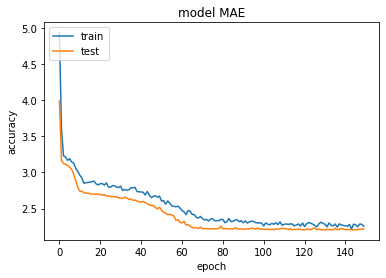

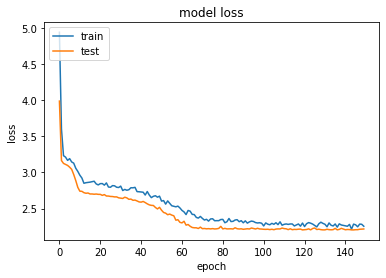

In [19]:
import matplotlib.pyplot as plt
# list all data in history
print(build.history.keys())
# summarize history for accuracy
plt.plot(build.history['mae'])
plt.plot(build.history['val_mae'])
plt.title('model MAE')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(build.history['loss'])
plt.plot(build.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
model.save("model-no-shuflle.h5")
print("Saved model to disk")

Saved model to disk


## save test result

In [24]:
submission = pd.read_csv("../data/sample_submission.csv", index_col='seg_id', dtype={"time_to_failure": np.float32})
X_sub = pd.DataFrame(columns=X_data.columns, dtype=np.float32)

for i, seg_id in enumerate(tqdm(submission.index)):
    seg = pd.read_csv('../data/test/' + str(seg_id) + '.csv')
    X_seg = create_features(seg, X_sub, i)

100%|██████████| 2624/2624 [00:52<00:00, 50.10it/s]


In [25]:
X_seg_array = np.reshape(X_seg.values, (X_seg.shape[0], X_seg.shape[1], 1))
pred_final = model.predict(X_seg_array)
submission['time_to_failure'] = pred_final

submission.to_csv('submission-LSTM.csv')

## plot the test acoustic data

            time_to_failure
seg_id                     
seg_004314         0.555704
seg_20cc25         0.983167
seg_26a2a0         0.348386
seg_272a47         0.939068
seg_2f86cd         0.408327
seg_376908         0.847941
seg_39ad50         0.535010
seg_3e87b4         0.597010
seg_5311d1         0.924789
seg_6f17de         0.997774
seg_724df9         0.353763
seg_7848f8         0.369655
seg_7a9f2b         0.357166
seg_7fa6ec         0.348553
seg_8be76c         0.767175
seg_90b174         0.773433
seg_919a6a         0.972501
seg_957ece         0.712432
seg_a1a511         0.975053
seg_a9089b         0.990989
seg_aa98cc         0.357945
seg_b35174         0.343291
seg_b686e5         0.570120
seg_bfdd14         0.597073
seg_c243a6         0.755406
seg_c5dee4         0.682533
seg_c80857         0.358782
seg_c94941         0.830885
seg_c9831a         0.825778
seg_e3d751         0.331345
seg_f43ab6         0.854497
seg_fdd50e         0.772728
<class 'pandas.core.frame.DataFrame'>
Index(['ti

/Users/lynette/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


seg_c80857
seg_c94941
seg_c9831a
seg_e3d751
seg_f43ab6
seg_fdd50e


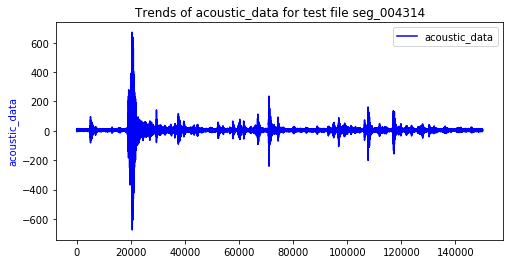

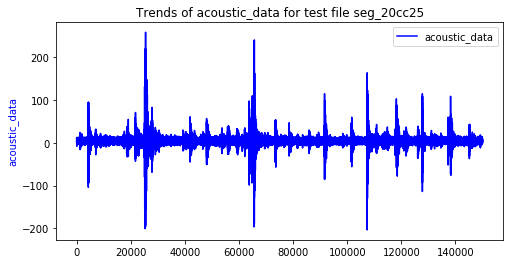

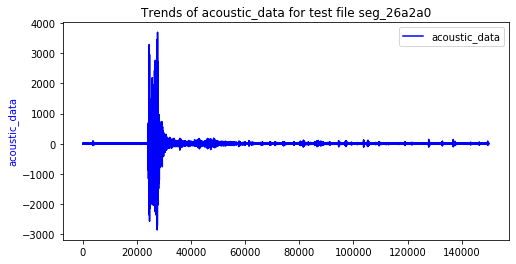

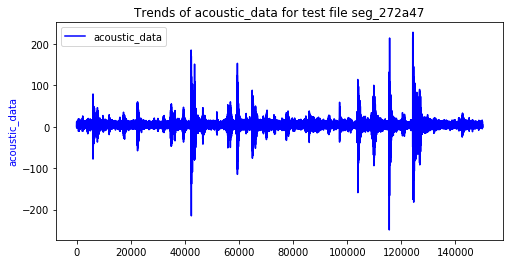

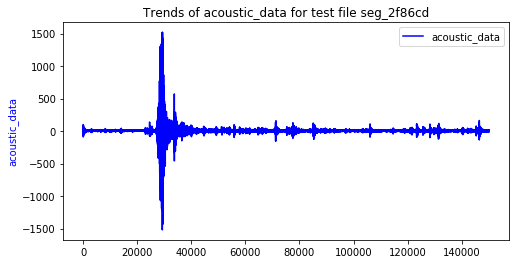

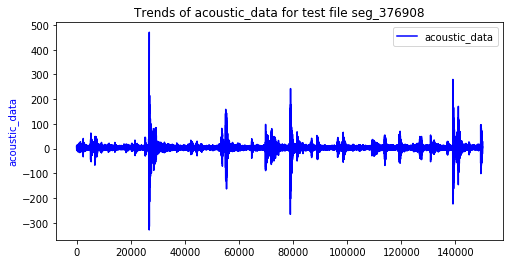

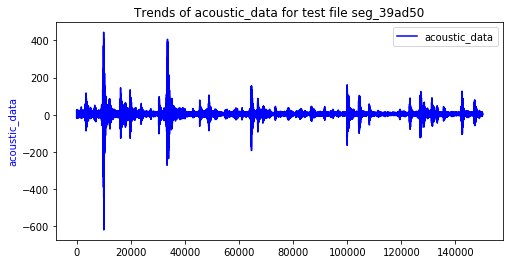

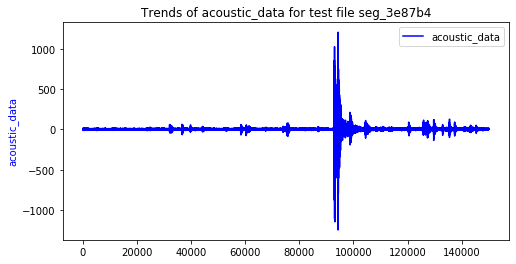

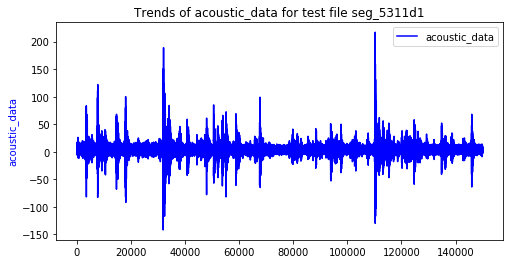

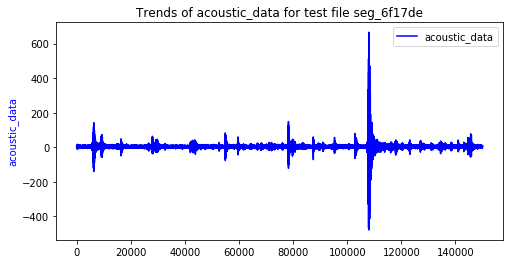

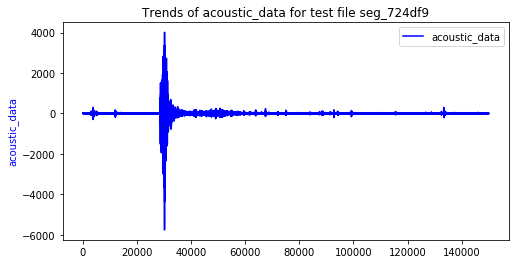

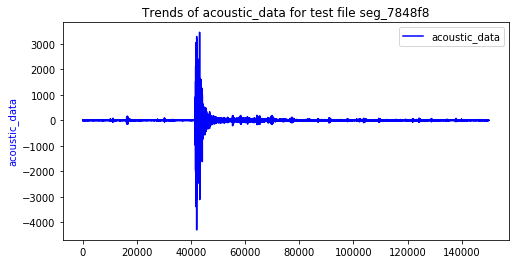

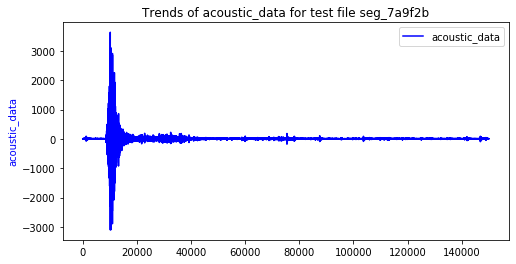

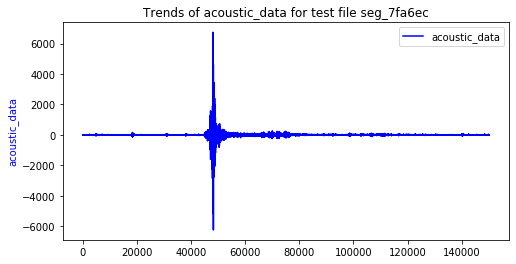

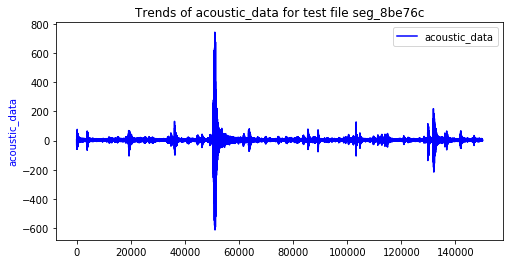

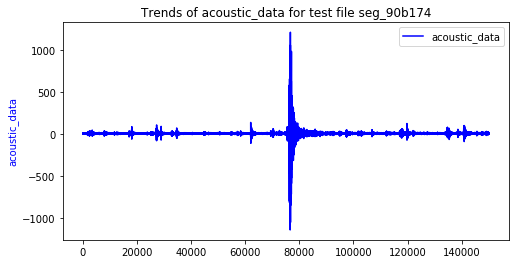

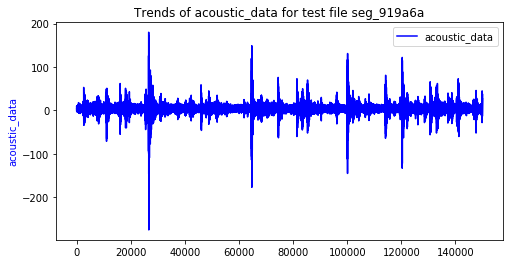

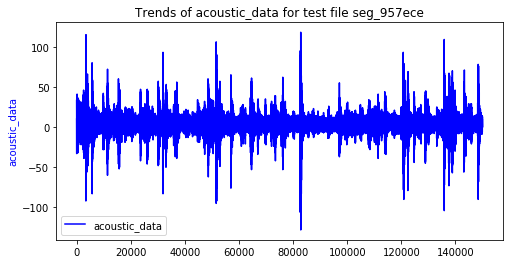

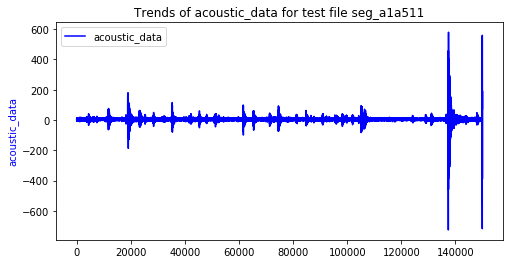

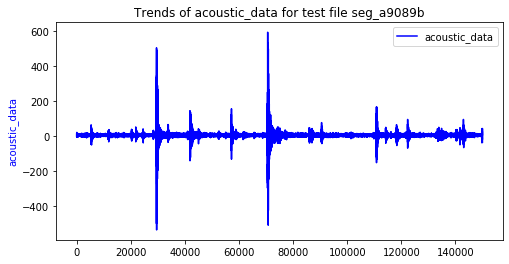

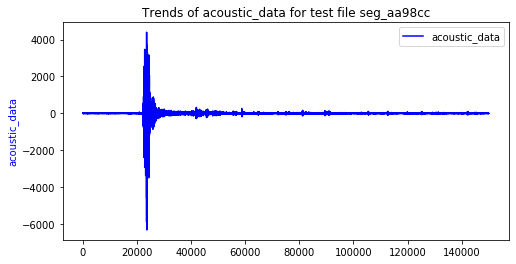

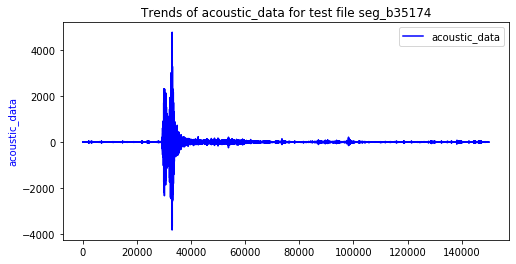

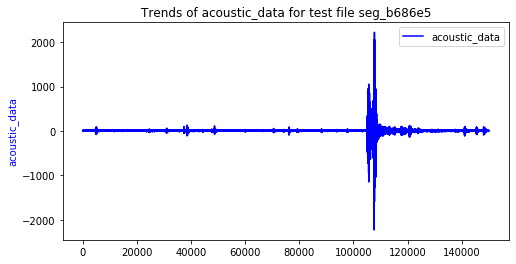

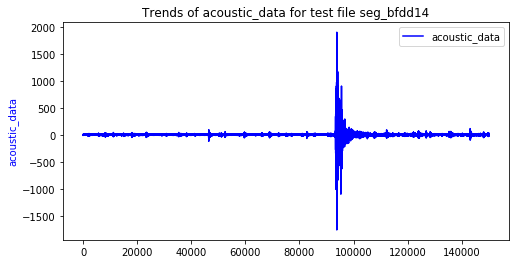

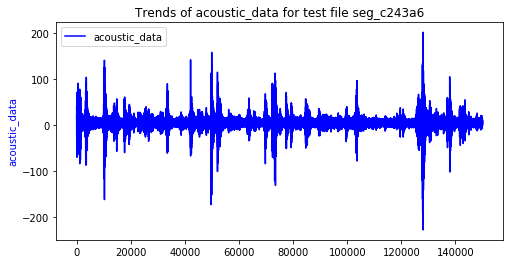

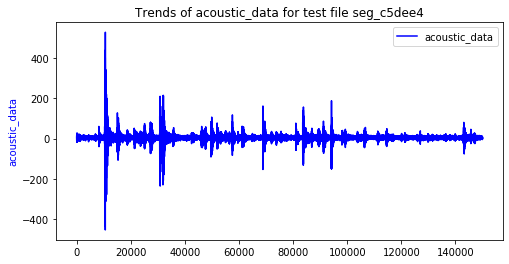

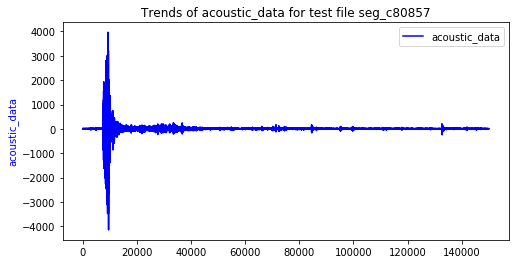

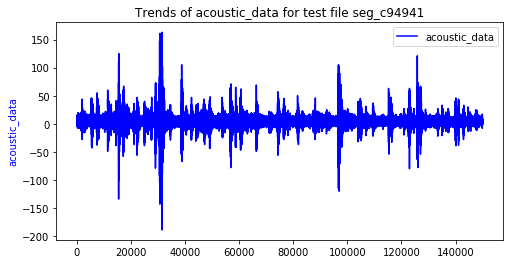

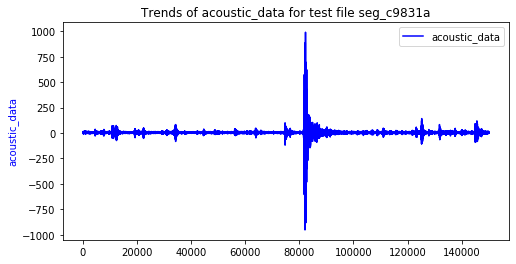

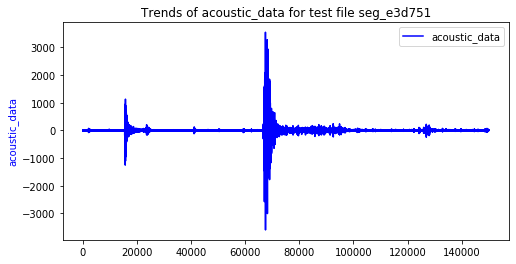

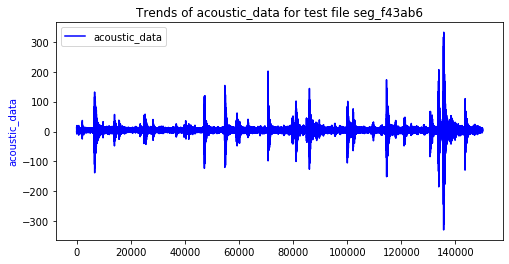

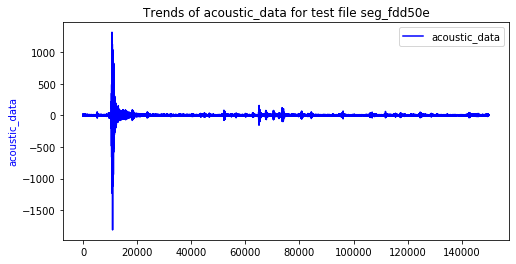

In [27]:
possible_eq = submission.loc[submission["time_to_failure"] < 1.0]
print(possible_eq)
print(type(possible_eq))
print(possible_eq.columns)
# segments = ["seg_26a2a0", "seg_724df9", "seg_7a9f2b", "seg_7fa6ec", "seg_aa98cc", "seg_b35174", "seg_c80857", "seg_e3d751"]

for seg_id in possible_eq.index:
    print(seg_id)
    seg = pd.read_csv('../data/test/' + seg_id + '.csv')
    fig, ax1 = plt.subplots(figsize=(8, 4))
    plt.title("Trends of acoustic_data for test file {}".format(seg_id))
    plt.plot(seg['acoustic_data'].values, color='b')
    ax1.set_ylabel('acoustic_data', color='b')
    plt.legend(['acoustic_data'])

In [1]:
from keras.models import load_model
 
# load model
model = load_model('model-no-shuflle.h5')
model.summary()



Using TensorFlow backend.
/Users/lynette/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/lynette/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/lynette/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/lynette/opt/anaconda3/lib/pytho

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 11, 1024)          2105344   
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 1024)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               1311744   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         


            time_to_failure
seg_id                     
seg_004314         0.555704
seg_20cc25         0.983167
seg_26a2a0         0.348386
seg_272a47         0.939068
seg_2f86cd         0.408327
seg_376908         0.847941
seg_39ad50         0.535010
seg_3e87b4         0.597010
seg_5311d1         0.924789
seg_6f17de         0.997774
seg_724df9         0.353763
seg_7848f8         0.369655
seg_7a9f2b         0.357166
seg_7fa6ec         0.348553
seg_8be76c         0.767175
seg_90b174         0.773433
seg_919a6a         0.972501
seg_957ece         0.712432
seg_a1a511         0.975053
seg_a9089b         0.990989
seg_aa98cc         0.357945
seg_b35174         0.343291
seg_b686e5         0.570120
seg_bfdd14         0.597073
seg_c243a6         0.755406
seg_c5dee4         0.682533
seg_c80857         0.358782
seg_c94941         0.830885
seg_c9831a         0.825778
seg_e3d751         0.331345
seg_f43ab6         0.854497
seg_fdd50e         0.772728
<class 'pandas.core.frame.DataFrame'>
Index(['ti

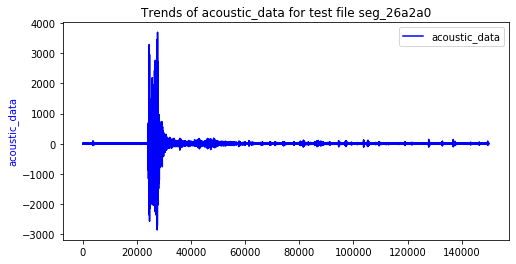

In [8]:
import matplotlib.pyplot as plt
possible_eq = submission.loc[submission["time_to_failure"] < 1.0]
print(possible_eq)
print(type(possible_eq))
print(possible_eq.columns)
segments = ["seg_26a2a0"]
for seg_id in segments:
    print(seg_id)
    seg = pd.read_csv('../data/test/' + seg_id + '.csv')
    fig, ax1 = plt.subplots(figsize=(8, 4))
    plt.title("Trends of acoustic_data for test file {}".format(seg_id))
    plt.plot(seg['acoustic_data'].values, color='b')
    ax1.set_ylabel('acoustic_data', color='b')
    plt.legend(['acoustic_data'])

In [5]:
submission = pd.read_csv("./submission-LSTM.csv", index_col='seg_id', dtype={"time_to_failure": np.float32})